# Instalação das Bibliotecas que iremos utilizar para a Análise

In [78]:
!pip install statsforecast
!pip install pmdarima

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from statsforecast import StatsForecast
from statsforecast.models import Naive, SeasonalNaive, SeasonalWindowAverage
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# Coleta dos Dados



In [166]:
#Os dados utilizados nesta analise, consideram o período de Jan/2020 até Jun/2024
dados = pd.read_csv('/content/Dados Históricos - Ibovespa.csv', sep=',', parse_dates=['Data'])
dados.sort_values(by='Data',ascending=True, inplace=True)

#Exibindo os 5 ultimos registros
dados.tail()

<ipython-input-166-d709825fc521>:2: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  dados = pd.read_csv('/content/Dados Históricos - Ibovespa.csv', sep=',', parse_dates=['Data'])


,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
4,2024-06-24,122.637,121.343,122.840,121.307,"7,84M","1,07%"
3,2024-06-25,122.331,122.634,122.849,121.997,"6,94M","-0,25%"
2,2024-06-26,122.641,122.331,122.701,121.402,"8,18M","0,25%"
1,2024-06-27,124.308,122.642,124.308,122.642,"8,71M","1,36%"
0,2024-06-28,123.907,124.308,124.500,123.298,"9,07M","-0,32%"


# Analise exploratória dos dados

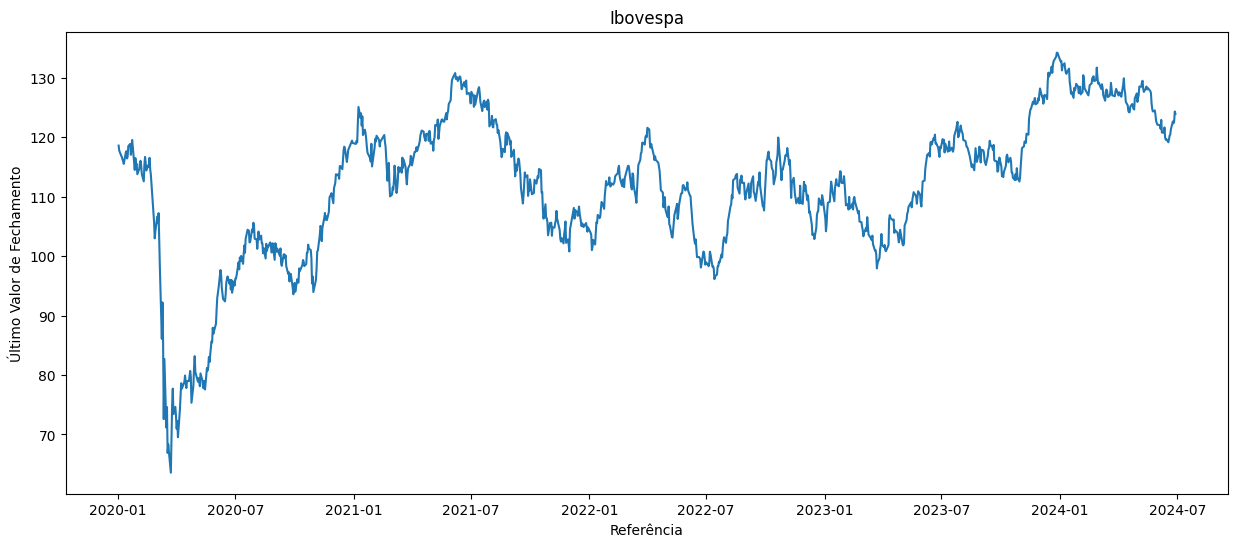

In [167]:
#Realizada a Plotagem do Gráfico para que possamos analisar todo o período que estaremos utilizando
plt.figure(figsize=(15,6))
plt.plot(dados['Data'], dados['Último'])
plt.title('Ibovespa')
plt.xlabel('Referência')
plt.ylabel('Último Valor de Fechamento')
plt.show()

In [168]:
#Padronizando os nomes das colunas
#DS = Data de Referëncia e Índice do DataFrame
#Y = Fechamento - Variável Target, é o valor que itemos realizar a predição a seguir.
#Z = Abertura - Variável que utilizaremos juntamente com a data para realizar a predição.
dados.rename(columns={'Data': 'ds', 'Último': 'y', 'Abertura': 'z'}, inplace=True)
dados.head()

,ds,y,z,Máxima,Mínima,Vol.,Var%
1117,2020-01-02,118.573,115.652,118.573,115.649,"5,16M","2,53%"
1116,2020-01-03,117.707,118.564,118.792,117.341,"6,83M","-0,73%"
1115,2020-01-06,116.878,117.707,117.707,116.269,"6,57M","-0,70%"
1114,2020-01-07,116.662,116.872,117.076,115.965,"4,85M","-0,18%"
1113,2020-01-08,116.247,116.667,117.335,115.693,"5,91M","-0,36%"


In [169]:
#Aqui estamos Deletando as colunas que não iremos realizar a utilização em nosso DataFrame
dados.drop(columns=['Máxima', 'Mínima', 'Vol.', 'Var%'], inplace=True)
dados.head()

,ds,y,z
1117,2020-01-02,118.573,115.652
1116,2020-01-03,117.707,118.564
1115,2020-01-06,116.878,117.707
1114,2020-01-07,116.662,116.872
1113,2020-01-08,116.247,116.667




*   Verificando a Estacionalidade dos dados




In [170]:
# Iniciamos o teste de Adfuller para verificar a estacionalidade dos dados.
adf_result = adfuller(dados['y'])
resultado = adf_result[1]

if resultado > 0.05:
    print(f'Resultado do teste ADF: {resultado}, ou seja, A série não é estacionária')
else:
    print(f'Resultado do teste ADF: {resultado}, ou seja,A série é estacionária')


Resultado do teste ADF: 0.14431398051450078, ou seja, A série não é estacionária


In [171]:
# Vendo que os dados não ficaram estacionarios apenas com o Adfuller
# Resolvemos utilizar a função de DIFF (Verifica a diferença entre elementos consecutivos)
# Essa função é responsável por calcular a variação ou mudança entre valores consecutivos.

dados['y_diff'] = dados['y'].diff().dropna()

adf_result_diff = adfuller(dados['y_diff'].dropna())
resultado_diff = adf_result[1]

if resultado > 0.05:
    print(f'Resultado do teste ADF: {resultado_diff}, ou seja, A série não é estacionária')
else:
    print(f'Resultado do teste ADF: {resultado_diff}, ou seja,A série é estacionária')


Resultado do teste ADF: 0.14431398051450078, ou seja, A série não é estacionária


In [172]:
# Criação das variáveis com a função Log

dados_log = np.log(dados['y'])
ma_log = dados_log.rolling(window=120).mean()

In [173]:
# Mesmo após a diferenciação, a serie continuou a não ser estacionária
# Utilizamos então as variáveis com a função log

dados_log = (dados_log - ma_log).dropna()
ma_s = dados_log.rolling(120).mean()
x_s = dados_log.values
result_s = adfuller(x_s)

print("Teste ADF")
print(f"Teste estatístico: {result_s[0]}")
print(f"p-Value: {result_s[1]}")
print(f"Valores Críticos:")

for key, value in result_s[4].items():
  print(f"\t{key}: {value}")

Teste ADF
Teste estatístico: -2.857147369809508
p-Value: 0.05056293014039087
Valores Críticos:
	1%: -3.4369193380671
	5%: -2.864440383452517
	10%: -2.56831430323573


In [174]:
# Após utilizar a função Log, conseguimos transformar em uma serie estacionária.

In [175]:
# Dropando a coluna para que possa ser utilizada em outros modelos sem interferência.
dados.drop(columns=['y_diff'], inplace=True)

*   Verificação da Sasonalidade

In [176]:
#Verificação da Sasonalidade dos dados - Período de 120 Meses
resultado = seasonal_decompose(dados['y'], model='multiplicative', period=120)

#Foi utilizado o período de 120 devido à melhor visualização do gráfico

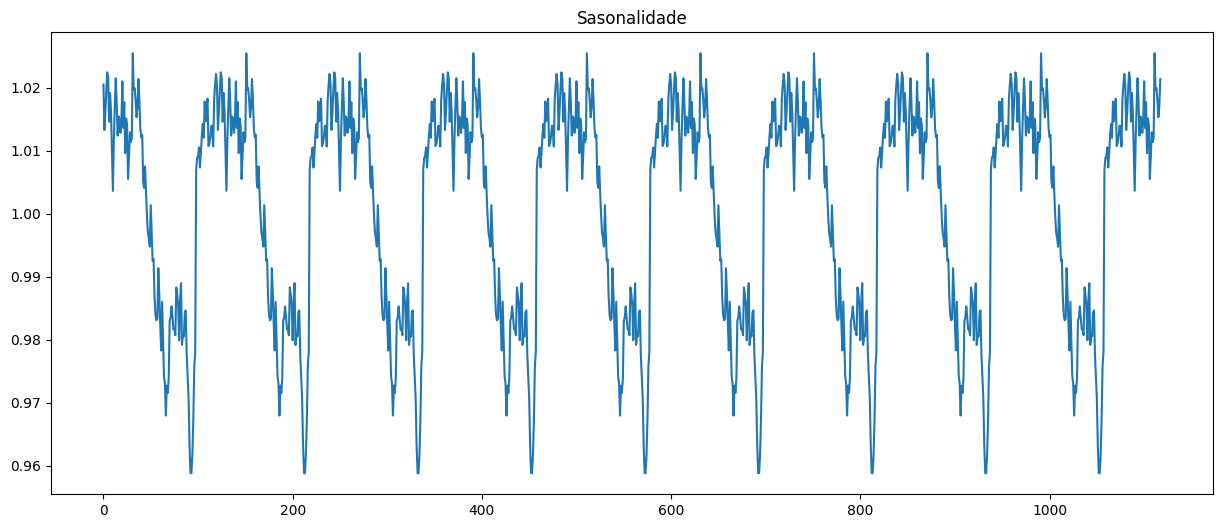

In [177]:
#Plotagem do Grafico de Sasonalidade
resultado.seasonal.plot(figsize=(15,6))
plt.title('Sasonalidade')
plt.show()

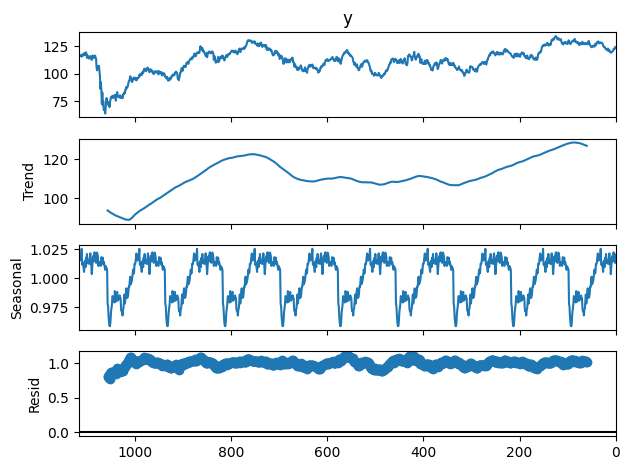

In [178]:
# Decomposição da série temporal
resultado.plot()
plt.show()

In [179]:
#Definição das base de 80% para treinamento e 20% para teste
train_size = int(len(dados) * 0.8)
train = dados[:train_size]
test  = dados[train_size:]
h = test['y'].nunique()

In [180]:
#Verificação do Tamanho das bases
print(train_size)
print(train.shape)
print(test.shape)

894
(894, 3)
(224, 3)


In [181]:
# Funções de Avaliação
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mae, mse, mape

# Função para mostras as métricas
def print_metrics(metrics):
    mae, mse, mape = metrics
    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print(f"MAPE: {mape}")

#Modelos#


## ARIMA ##

In [182]:
# Definição das variáveis
df = dados.copy()
treino = train.copy()
teste = test.copy()
passos = h

In [183]:
# Definindo a data como index do DataFrame
df.set_index('ds', inplace=True)
treino.set_index('ds', inplace=True)
teste.set_index('ds', inplace=True)

In [184]:
# Realizando o Drop da Coluna que não será necessário
df.drop(columns=['z'], inplace=True)
treino.drop(columns=['z'], inplace=True)
teste.drop(columns=['z'], inplace=True)

In [185]:
# Definindo com o AUTO_ARIMA quais são os melhores parâmetros com base em nossos dados.
model_auto = auto_arima(df, seasonal=False, trace=True)
print(model_auto.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4277.609, Time=1.87 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4292.317, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4278.118, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4279.955, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4290.327, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4277.260, Time=0.57 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4275.707, Time=0.26 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4277.082, Time=0.41 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4278.385, Time=0.41 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4275.744, Time=1.38 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4273.718, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4277.967, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4275.270, Time=0.22 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4275.092, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0]          

In [186]:
# Treinando o Modelo Arima
model = ARIMA(treino, order=(0, 1, 2))
model_fit = model.fit()

#Definindo a Variável de Predição e ajustando o modelo para um DataFrame
forecast_arima = model_fit.forecast(steps=passos, freq='B')
forecast_arima = pd.DataFrame(forecast_arima)
forecast_arima.rename(columns={'predicted_mean': 'yhat'}, inplace=True)
forecast_arima['ds'] = teste.index
forecast_arima.set_index('ds', inplace=True)

#Realizando os cálculos das métricas do modelo.
pred_arima = calculate_metrics(teste['y'], forecast_arima['yhat'])
print_metrics(pred_arima)

MAE: 5.864501866030833
MSE: 43.33667644495718
MAPE: 4.6770491707404025


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

## Naive, SeasonalNaive, SeasonalWindowAverage ##

In [187]:
#Definição de nova variá vel para utilizar em outro modelo.
df_1 = dados.copy()
df_1

,ds,y,z
1117,2020-01-02,118.573,115.652
1116,2020-01-03,117.707,118.564
1115,2020-01-06,116.878,117.707
1114,2020-01-07,116.662,116.872
1113,2020-01-08,116.247,116.667
...,...,...,...
4,2024-06-24,122.637,121.343
3,2024-06-25,122.331,122.634
2,2024-06-26,122.641,122.331
1,2024-06-27,124.308,122.642


In [188]:
#inclusão de uma nova coluna para utilização do modelo
df_1['unique_id'] = 1

In [189]:
#Definição das Bases de Treino e Teste
train_size_k = int(len(df_1) * 0.8)
train_k = df_1[:train_size]
test_k  = df_1[train_size:]
h_k = test['ds'].nunique()

In [190]:
train

,ds,y,z
1117,2020-01-02,118.573,115.652
1116,2020-01-03,117.707,118.564
1115,2020-01-06,116.878,117.707
1114,2020-01-07,116.662,116.872
1113,2020-01-08,116.247,116.667
...,...,...,...
228,2023-07-28,120.187,120.002
227,2023-07-31,121.943,120.188
226,2023-08-01,121.248,121.945
225,2023-08-02,120.859,121.249


In [191]:
#Modelo Statsforecas, Predição sem Sazonalidade
model_n = StatsForecast(models=[Naive()], freq=	'B', n_jobs=-1)
model_n.fit(train_k)

forecast_n = model_n.predict(h=h_k)

wmape1 = calculate_metrics(test_k['y'], forecast_n['Naive'].values)
print_metrics(wmape1)

MAE: 5.849036185128348
MSE: 43.03125043390979
MAPE: 4.666037808616484


/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:492: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [192]:
#Modelo Statsforecas, Predição com Sazonalisade
model_s = StatsForecast(models=[SeasonalNaive(season_length=10)], freq=	'B', n_jobs=-1)
model_s.fit(train_k)

forecast_dfs = model_s.predict(h=h_k)

wmape2 = calculate_metrics(test_k['y'], forecast_dfs['SeasonalNaive'].values)
print_metrics(wmape2)

MAE: 5.706665069852556
MSE: 40.7560717884223
MAPE: 4.5674147788656985


/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:492: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [193]:
#Modelo Statsforecas, Predição com Sazonalisade e Média Movel
model_sm = StatsForecast(models=[SeasonalWindowAverage(season_length=10, window_size=4)], freq=	'B', n_jobs=-1)
model_sm.fit(train_k)

forecast_dfsm = model_sm.predict(h=h_k)

wmape3 = calculate_metrics(test_k['y'], forecast_dfsm['SeasWA'].values)
print_metrics(wmape3)

MAE: 6.438857333319527
MSE: 55.45746671046026
MAPE: 5.096280173520567


/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:492: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


##Phophet##

In [194]:
#Definição das Bases de Treino e Teste para o modelo de Prophet
train_size_p = int(len(df_1) * 0.8)
train_p = df_1[:train_size]
test_p  = df_1[train_size:]
h_p = test['ds'].nunique()

In [195]:
#Treinamento do Modelo Prophet
model_p = Prophet(daily_seasonality=False)
model_p.add_regressor('z')
model_p.fit(train_p)

#Previsão do Modelo

future_p = model_p.make_future_dataframe(periods=h_p, freq='B')
future_p['z'] = pd.concat([train_p['z'], test_p['z']], ignore_index=True)
forecast_p = model_p.predict(future_p)

preds_p = forecast_p[["ds", "yhat"]].tail(len(test_p))

#Cálculo das métricas
prophet_m = calculate_metrics(test_p['y'], preds_p['yhat'].values)
print_metrics(prophet_m)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp5r6eqx4c/sgi43edn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5r6eqx4c/1f40hbvl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8935', 'data', 'file=/tmp/tmp5r6eqx4c/sgi43edn.json', 'init=/tmp/tmp5r6eqx4c/1f40hbvl.json', 'output', 'file=/tmp/tmp5r6eqx4c/prophet_model6pel_r_l/prophet_model-20240728134228.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:42:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:42:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.8930310914256899
MSE: 1.242133683723621
MAPE: 0.7228539260827419


#Considerações Finais #

In [196]:
Resultados_Gerais = pd.DataFrame([wmape1,wmape2,wmape3,prophet_m, pred_arima],
                  columns=['MAE','MSE','MAPE'],
                  index=['Naive','SeasonalNaive','SeasonalWindowAverage','Prophet','Arima'])
Resultados_Gerais.sort_values(by='MAPE', ascending=True, inplace=True)

Resultados_Gerais

,MAE,MSE,MAPE
Prophet,0.893031,1.242134,0.722854
SeasonalNaive,5.706665,40.756072,4.567415
Naive,5.849036,43.031250,4.666038
Arima,5.864502,43.336676,4.677049
SeasonalWindowAverage,6.438857,55.457467,5.096280


Neste notebook, analisamos os valores de fechamento Ibovespa.

Ao realizar toda a análise exploratória dos dados, verificamos que entre os cinco modelos analisados que foram o Arima, Phophet, Naive, SeasonalNaive e SeasonalWindowAverage.

O modelo que obteve os melhores resultados foi o Prophet.

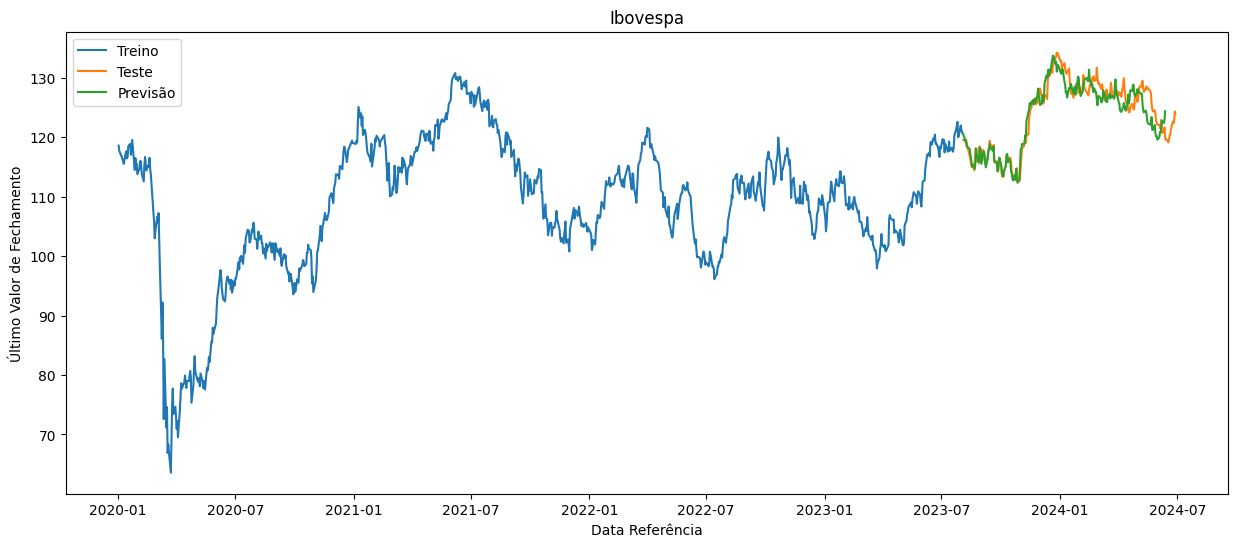

In [197]:
#Plotagem do Gráfico que obteve as melhores médias

plt.figure(figsize=(15,6))
plt.plot(train_p['ds'],train_p['y'], label='Treino')
plt.plot(test_p['ds'], test_p['y'], label='Teste')
plt.plot(preds_p['ds'], preds_p['yhat'], label='Previsão')
plt.xlabel('Data Referência')
plt.ylabel('Último Valor de Fechamento')
plt.title('Ibovespa')
plt.legend()